In [26]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mssmartypants/rice-type-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/rice-type-classification


In [3]:
df = pd.read_csv('riceClassification.csv')

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
df.dropna(inplace=True)
df.drop('id',axis=1,inplace=True)
df.shape

(18185, 11)

In [6]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [7]:
df['Class'].value_counts()

,count
Class,
1,9985
0,8200


## Normalize the df


In [8]:
o_df = df.copy()
for col in df.columns:
  df[col] = df[col]/df[col].abs().max()

df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [9]:
X = np.array(df.iloc[:, :-1])
Y = np.array(df.iloc[:,-1])
print(X,Y)

[[0.44436827 0.50340371 0.77543522 ... 0.5370287  0.844997   0.36831616]
 [0.28129285 0.40768133 0.62265269 ... 0.40966075 0.91921498 0.37147093]
 [0.29853085 0.41642141 0.63044229 ... 0.41299402 0.95986205 0.37474651]
 ...
 [0.62340842 0.84480035 0.64091576 ... 0.67304935 0.75472018 0.74783024]
 [0.58374143 0.8263563  0.62355087 ... 0.67524793 0.70210346 0.75187447]
 [0.60078355 0.83554818 0.62495614 ... 0.6658912  0.74305096 0.7585284 ]] [1. 1. 1. ... 0. 0. 0.]


In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3)

In [11]:
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5)

In [12]:
print(X_test.shape)
print(X_val.shape)
print(X_train.shape)

(2728, 10)
(2728, 10)
(12729, 10)


In [13]:
class dataset(Dataset):
  def __init__(self,X,Y):
    self.X =torch.tensor(X, dtype = torch.float32).to(device)
    self.Y =torch.tensor(Y, dtype = torch.float32).to(device)


  def __len__(self):
      return len(self.X)
  def __getitem__(self,index):
      return self.X[index],self.Y[index]

In [14]:
train_data = dataset(X_train,y_train)
val_data = dataset(X_test,y_test)
test_data = dataset(X_val,y_val)

In [15]:
train_dataloader = DataLoader(train_data, batch_size = 8, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size = 8, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size = 8, shuffle=True)

In [16]:
HIDDEN_NEURONS = 10
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel,self).__init__()

    self.input_layer = nn.Linear(X.shape[1],HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS,1)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

model = MyModel().to(device)


In [17]:
summary(model,(X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [18]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(),lr=1e-3)

In [19]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10
for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    model.train()
    for data in train_dataloader:
        inputs, labels = data
        prediction = model(inputs).squeeze(1)
        batch_loss = criterion(prediction, labels)
        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()
        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data
            prediction = model(inputs).squeeze(1)
            batch_loss = criterion(prediction, labels)
            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()
            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train / len(train_dataloader), 4))
    total_loss_validation_plot.append(round(total_loss_val / len(val_dataloader), 4))
    total_acc_train_plot.append(round(total_acc_train /train_data.__len__() * 100, 4))
    total_acc_validation_plot.append(round(total_acc_val / val_data.__len__() * 100, 4))

    print(f'''Epoch no: {epoch + 1}
Train Loss: {round(total_loss_train / len(train_dataloader), 4)}
Train Accuracy: {round(total_acc_train / train_data.__len__() * 100, 4)}%
Val Loss: {round(total_loss_val / len(val_dataloader), 4)}
Val Accuracy: {round(total_acc_val / val_data.__len__() * 100, 4)}%''')
    print("=" * 100)


Epoch no: 1 
Train Loss: 0.3728 
Train Accuracy: 91.1619% 
Val Loss: 0.1217 
Val Accuracy: 98.8636%
Epoch no: 2 
Train Loss: 0.0855 
Train Accuracy: 98.3345% 
Val Loss: 0.0523 
Val Accuracy: 99.0469%
Epoch no: 3 
Train Loss: 0.0556 
Train Accuracy: 98.4759% 
Val Loss: 0.0387 
Val Accuracy: 99.0103%
Epoch no: 4 
Train Loss: 0.0477 
Train Accuracy: 98.5781% 
Val Loss: 0.0362 
Val Accuracy: 99.0103%
Epoch no: 5 
Train Loss: 0.0451 
Train Accuracy: 98.5152% 
Val Loss: 0.0361 
Val Accuracy: 98.937%
Epoch no: 6 
Train Loss: 0.0441 
Train Accuracy: 98.5545% 
Val Loss: 0.0331 
Val Accuracy: 99.0836%
Epoch no: 7 
Train Loss: 0.0435 
Train Accuracy: 98.6723% 
Val Loss: 0.0309 
Val Accuracy: 99.0469%
Epoch no: 8 
Train Loss: 0.044 
Train Accuracy: 98.5231% 
Val Loss: 0.0309 
Val Accuracy: 99.0469%
Epoch no: 9 
Train Loss: 0.0433 
Train Accuracy: 98.5781% 
Val Loss: 0.031 
Val Accuracy: 99.0469%
Epoch no: 10 
Train Loss: 0.0437 
Train Accuracy: 98.5309% 
Val Loss: 0.0318 
Val Accuracy: 98.9736%


In [21]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in test_dataloader:
    inputs, labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss_test =criterion(prediction,labels).item()
    batch_loss_test += batch_loss_test

    acc = ((prediction).round() == labels).sum().item()

    total_acc_test += acc

  print(f'''Accuracy: {round(total_acc_test/test_data.__len__()*100,4)}
    ''')

Accuracy: 98.607
    


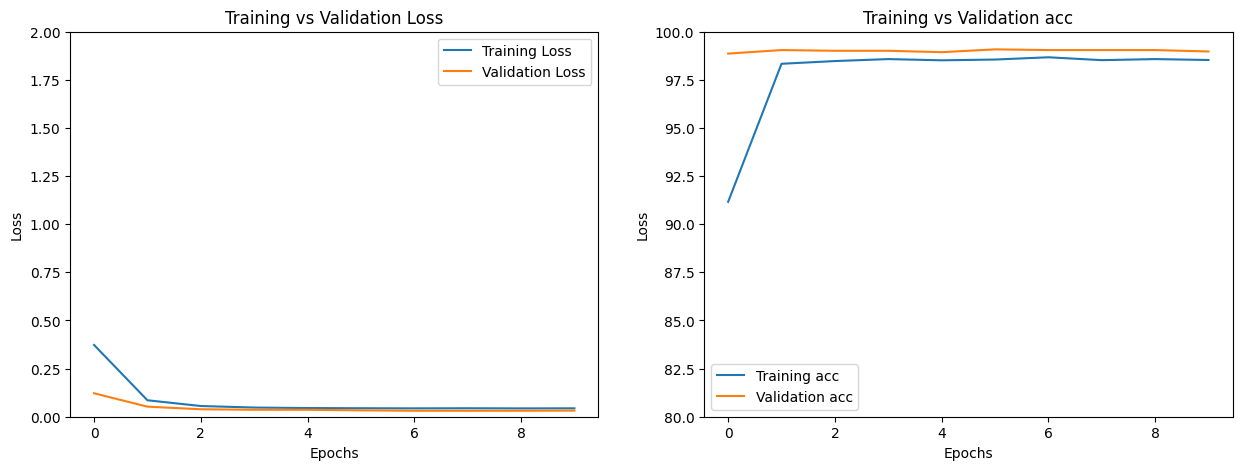

In [24]:
# total_loss_train_plot = []
# total_loss_validation_plot = []
# total_acc_train_plot = []
# total_acc_validation_plot = []

fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot,label= 'Training Loss')
axs[0].plot(total_loss_validation_plot,label='Validation Loss')
axs[0].set_title("Training vs Validation Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot,label= 'Training acc')
axs[1].plot(total_acc_validation_plot,label='Validation acc')
axs[1].set_title("Training vs Validation acc")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_ylim([80,100])
axs[1].legend()

plt.show()
